!pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [36]:
# Lib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [37]:
# Load the time series data
df = pd.read_csv("../epidemic_curve.csv")
df.head()


,date,cases
0,2024-01-01,0
1,2024-01-08,0
2,2024-01-15,46
3,2024-01-22,40
4,2024-01-29,3


In [38]:
# Prepare the data for Chronos
'''
Extract the numeric series (the cases column) and convert it to a PyTorch tensor. 

Chronos expects a 1D tensor (or a batch of 1D tensors) as input.
'''

context=torch.tensor(df["cases"].values, dtype=torch.float32)

In [39]:
context.shape # This creates context, a 1D tensor of length 40 (for 40 weeks)

torch.Size([40])

In [40]:
# Load the pre-trained Chronos model
'''
Use ChronosPipeline.from_pretrained to load the Chronos-T5 model.

The resulting pipeline object encapsulates the model and will be used for prediction.
'''
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps") # This will download the amazon/chronos-t5-small model and initialize a forecasting pipeline
# Also i can use device_map="auto" to use GPU if available or device_map="mps" for my MacBook laptop

'''
We can switch to chronos-t5-large or any other model just by changing the model name.
For example:
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="mps")
                (or)
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps")
                (or)
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="mps")
                ...

                
'''


'\nWe can switch to chronos-t5-large or any other model just by changing the model name.\nFor example:\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="mps")\n                (or)\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps")\n                (or)\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="mps")\n                ...\n\n\n'

In [41]:
# Forecast the next 4 weeks
'''
Call pipeline.predict with the context tensor and prediction_length=4 to forecast the next 4 time steps.
'''

prediction_length = 4 # We want to forecast the next 4 weeks
forecast = pipeline.predict(context, prediction_length) # shape [num_series, num_samples, prediction_length]


In [42]:
forecast.shape # This creates forecast, a 1D tensor of length 4 (for 4 predicted weeks)

torch.Size([1, 20, 4])

This runs the model to predict 4 future weekly values. Internally, Chronos generates many sample trajectories; as shown above, the output forecast will have shape `[num_series, num_samples, prediction_length]`. 

Here **num_series=1 (one time series)** and **prediction_length=4**. 

For example, if the default num_samples is 20, then forecast.shape would be (1, 20, 4).

In [43]:
forecast[0] # (shape [num_samples, 4]) to see all sampled forecasts. The predicted values for the next 4 weeks

tensor([[ 2.2270e+01,  7.0726e-06,  7.0726e-06,  7.0726e-06],
        [ 7.0726e-06,  2.5982e+01,  5.5675e+01,  7.0726e-06],
        [ 7.0726e-06,  8.1657e+01,  3.7117e+00,  2.2270e+01],
        [ 8.5369e+01,  1.7074e+02,  2.4126e+02,  2.7095e+02],
        [ 7.0726e-06,  7.4234e+00,  7.0726e-06,  7.0726e-06],
        [ 5.9387e+01,  7.0726e-06,  7.7946e+01,  8.5369e+01],
        [ 7.0726e-06,  3.7117e+00,  3.7117e+01,  4.8252e+01],
        [ 7.0726e-06,  4.4540e+01,  7.0726e-06,  2.5982e+01],
        [ 7.0726e-06,  7.0726e-06,  1.1135e+01,  3.7117e+00],
        [ 7.0726e-06,  8.5369e+01,  7.0726e-06,  3.7117e+00],
        [ 7.0726e-06,  7.0726e-06, -3.7117e+00, -3.7117e+00],
        [ 3.7117e+00,  7.0726e-06,  7.0726e-06,  7.4234e+00],
        [ 5.9387e+01,  1.1135e+01,  1.8187e+02,  2.2270e+01],
        [ 7.0726e-06,  7.0726e-06,  4.0829e+01,  4.0829e+01],
        [ 1.8558e+01,  7.0726e-06,  1.8558e+01,  3.7117e+01],
        [ 7.0726e-06,  2.9694e+01,  4.8252e+01,  1.4847e+02],
        

In [44]:
# Chronos produces a distribution of future values
# Visualize the forecast

forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

print("Low (10th percentile) forecast for next 4 weeks:", low)
print("Median (50th percentile) forecast for next 4 weeks:", median)
print("High (90th percentile) forecast for next 4 weeks:", high)


Low (10th percentile) forecast for next 4 weeks: [7.07258005e-06 7.07258005e-06 7.07258005e-06 7.07258005e-06]
Median (50th percentile) forecast for next 4 weeks: [ 1.85585392  5.56754744 16.70262718 29.69355392]
High (90th percentile) forecast for next 4 weeks: [59.38710403 82.02843399 88.33831329 91.67883606]


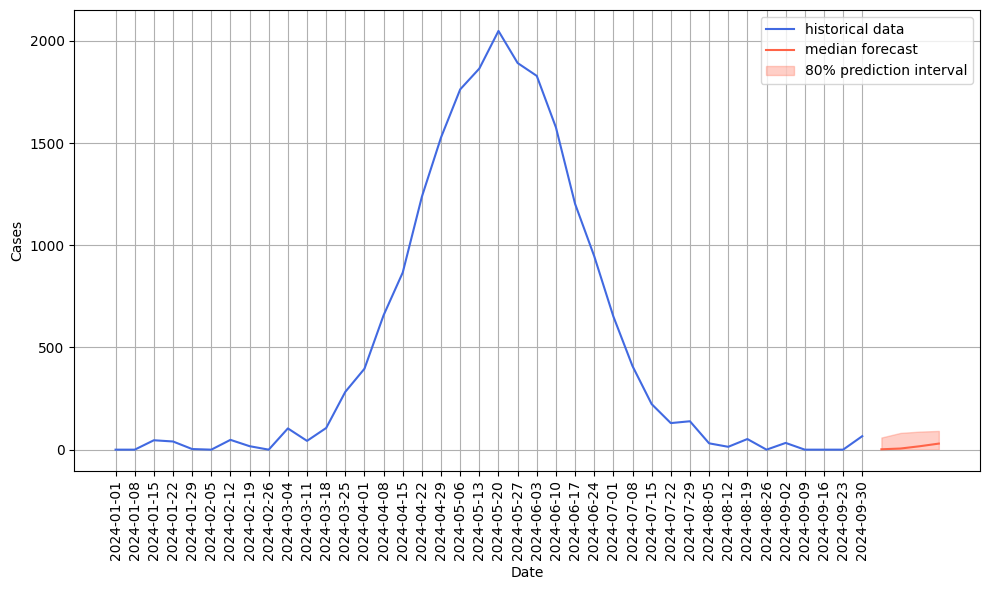

In [45]:
# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["cases"], color="royalblue", label="historical data")
#plt.plot(forecast_dates, median, color="tomato", label="median forecast")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.xlabel("Date")
plt.xticks(rotation=90)

plt.ylabel("Cases")

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

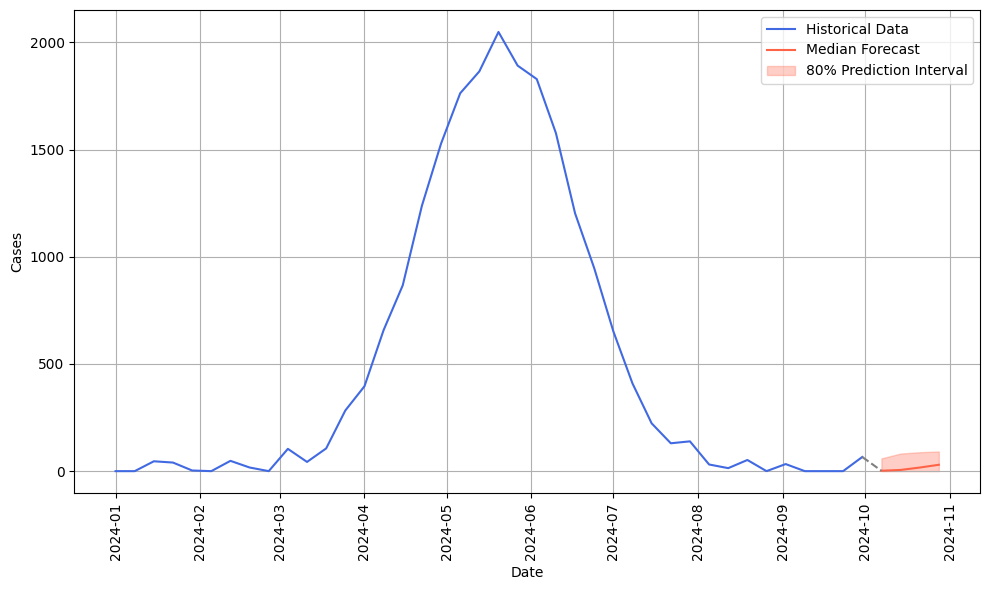

In [46]:
# Ensure 'date' is datetime
df["date"] = pd.to_datetime(df["date"])

# Existing values
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Create forecast_dates: next 4 weeks after last date
forecast_dates = pd.date_range(start=df["date"].iloc[-1] + pd.Timedelta(weeks=1),
                               periods=prediction_length, freq="W-MON")

# Combine all dates for x-axis
full_dates = pd.concat([df["date"], pd.Series(forecast_dates)])

# Combine all values for plotting reference line (optional)
full_cases = pd.concat([df["cases"], pd.Series([None]*prediction_length)])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["cases"], color="royalblue", label="Historical Data")
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.tight_layout()

# Add this before plt.show()
plt.plot([df["date"].iloc[-1], forecast_dates[0]],
         [df["cases"].iloc[-1], median[0]],
         color="gray", linestyle="--", label="Forecast Start")

plt.show()




In [47]:
# Print forecasted 4 weeks with dates
print("\nForecasted Cases (Next 4 Weeks):")
for d, c in zip(forecast_dates, median):
    print(f"{d.strftime('%Y-%m-%d')}: {round(c, 2)} cases")


Forecasted Cases (Next 4 Weeks):
2024-10-07: 1.86 cases
2024-10-14: 5.57 cases
2024-10-21: 16.7 cases
2024-10-28: 29.69 cases


**Q. Why not use `forecast_index`? It seems to work — so what’s the issue?** <br>
Answer:<br>
using `forecast_index = range(len(df), len(df) + prediction_length)` does work visually, but:<br>
| 🔴 `forecast_index`                     | 🟢 `forecast_dates`                                |
| --------------------------------------- | -------------------------------------------------- |
| Just integer indices (e.g. 40, 41, 42…) | Real calendar dates (e.g. 2024-10-28, 2024-11-04…) |
| Doesn't align with actual time units    | Proper date-based timeline                         |
| Breaks x-axis readability / exports     | Works seamlessly with time-based charts & CSV      |

So, <br>
- If x-axis is numeric (just positions), `forecast_index` is OK.
- If we want **real dates** then use `forecast_dates`


### Evaluate Chronos with MAE, RMSE, $R^2$

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [49]:
# Split into train/test
train_data = df["cases"].iloc[:-prediction_length]
test_data = df["cases"].iloc[-prediction_length:]

'''
First 36 weeks for training (input to Chronos)
Last 4 weeks as test set (what Chronos should predict)
'''

# Convert train to tensor
context_train = torch.tensor(train_data.values, dtype=torch.float32)

In [50]:
# Forecast with Chronos

forecast = pipeline.predict(context_train, prediction_length=prediction_length)
median_forecast = np.quantile(forecast[0].numpy(), 0.5, axis=0)


In [51]:
# Evaluate
y_true = test_data.values  # Actual values (last 4 weeks)
y_pred = median_forecast   # Chronos predictions

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse =  mse ** 0.5
r2 = r2_score(y_true, y_pred)

# Print evaluation metrics
print("Evaluation on Held-Out Test Set")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")


Evaluation on Held-Out Test Set
MAE:  53.90
RMSE: 57.11
R²:   -2.99
